## TT03: Finalize RAG Model

---

### Load the preprocessing pipeline (From TT02)

In [1]:
#we can import different modules for the functionality we want
import sentence_transformers
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

#also had to pip install pypdf (if not already done) and pip install sentence_transformers

#create document store
document_store = InMemoryDocumentStore()

#indicate the types of files to expect
file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf"])

#we need converters for the types of documents we are getting
text_file_converter = TextFileToDocument()
pdf_converter = PyPDFToDocument()

#this will join all our documents so they can be fed through the pipeline together
document_joiner = DocumentJoiner()

#add cleaning and preprocessing functions
document_cleaner = DocumentCleaner() #standardizes and removes extra whitespace
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50) #chunks the text with overlap for context, like we did with spaCy

#create document embeddings
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2") #use prebuilt model
document_embedder.warm_up() #download the embedding model

#write the processed documents to the InMemboryDocumentStore
document_writer = DocumentWriter(document_store)

preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

from pathlib import Path

# get all our documents
folder_path = "./TT02_Document_Library/"
files = list(Path(folder_path).rglob("*"))

# run the pipeline
preprocessing_pipeline.run({"file_type_router": {"sources": files}})

c:\Users\emtay\Documents\CityU\Winter_2024-25\DIT650\new_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


{'document_writer': {'documents_written': 23971}}

## View the preprocessing pipeline structure
---

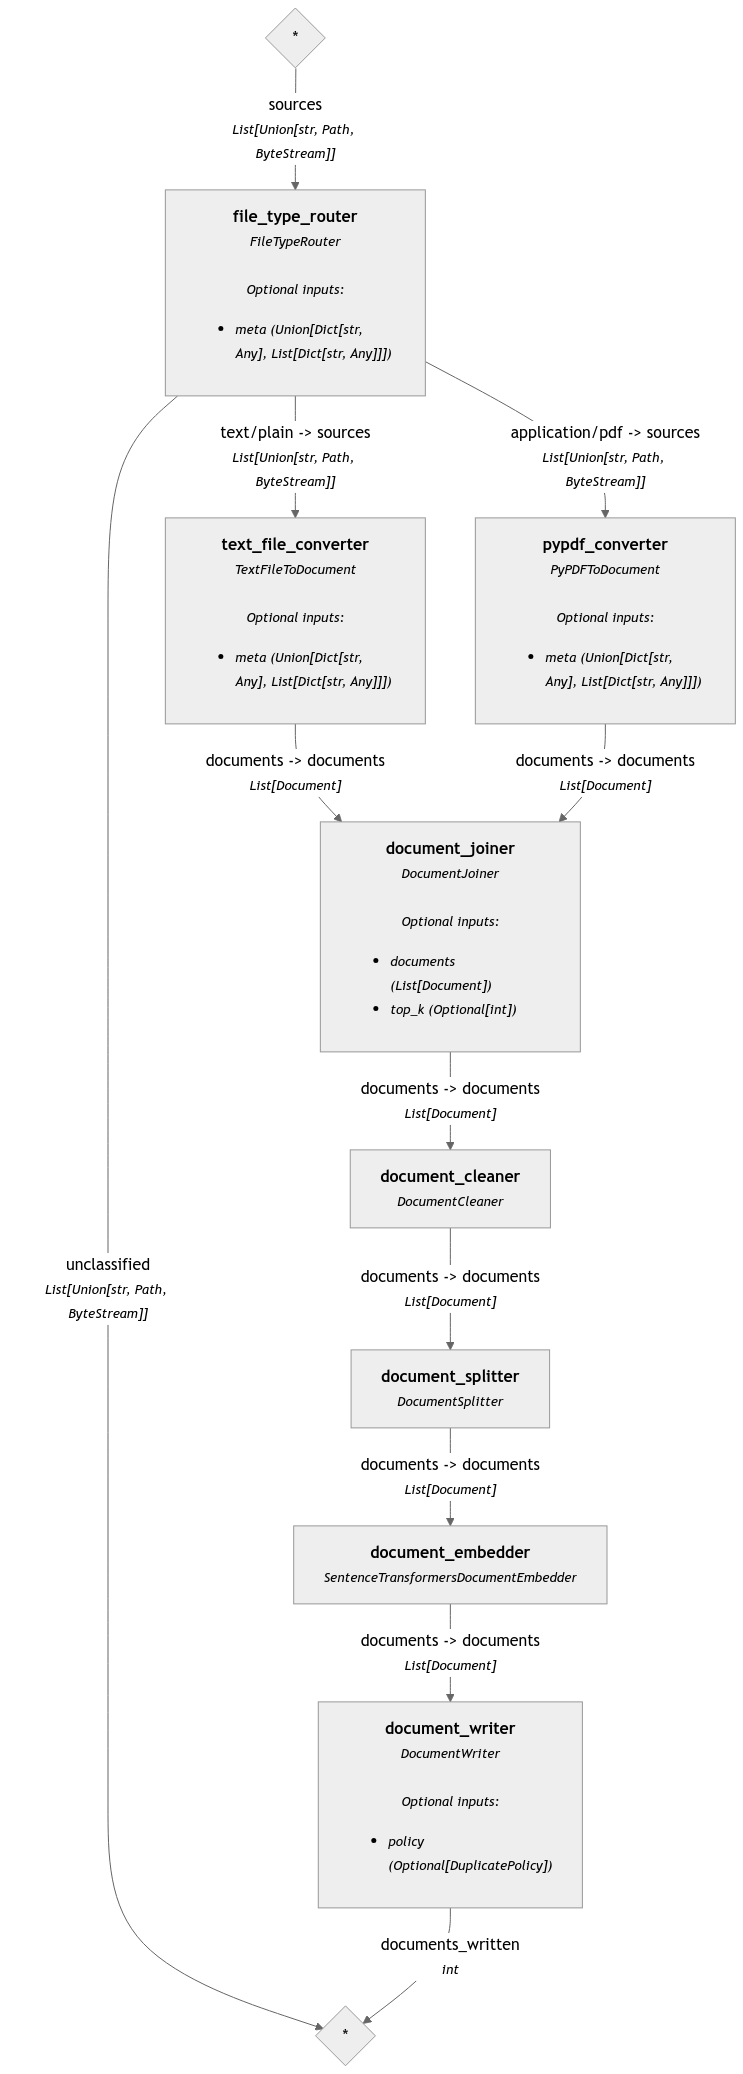

In [6]:
preprocessing_pipeline.show()

## Add the RAG Model (Retriever + Generator + Prompt Engineering)
---

In [10]:
#import libraries
import os
from getpass import getpass
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.joiners import DocumentJoiner

### API Key

In [11]:
# Ensure OpenAI API Key is Set
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

### Prompt Engineering for strutured output

In [12]:
# Define Chat Prompt Template
template = [
    ChatMessage.from_user(
        """
You are an AI assistant specializing in emergency medical triage. 
Your task is to assess patient cases, determine the urgency level, and provide the best immediate recommendations.

Guidelines:
- Red (Critical): Immediate life-threatening condition (e.g., heart attack, stroke).
- Yellow (Urgent): Needs prompt medical attention but not critical (e.g., moderate breathing difficulty).
- Green (Non-Urgent): Minor conditions (e.g., mild fever, minor injuries).

### Patient Case Information:
{% for document in documents %}
    - {{ document.content }}
{% endfor %}

### Patient Query:
{{ question }}

### Triage Decision & Rationale:
"""
    )
]

### RAG Model Setup

In [5]:
# Initialize Retriever
retriever = InMemoryBM25Retriever(document_store)

# Initialize Components
prompt_builder = ChatPromptBuilder(template=template)
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini")
document_joiner = DocumentJoiner()

# initialize rag pipeline
rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("document_joiner", document_joiner)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", chat_generator)

# Connect Components
rag_pipeline.connect("retriever.documents", "document_joiner.documents")
rag_pipeline.connect("document_joiner", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")

print("✅ Pipeline Successfully Configured!")



✅ Pipeline Successfully Configured!


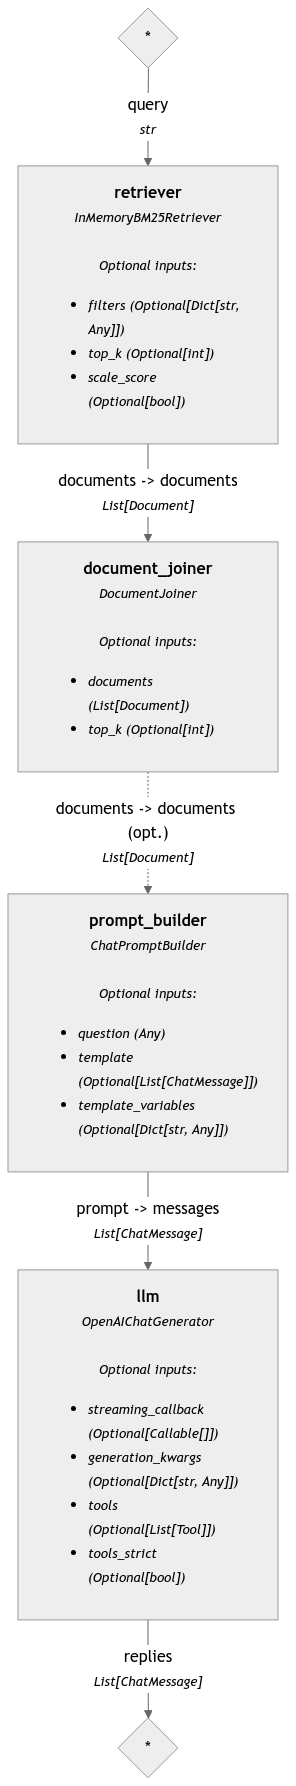

In [13]:
rag_pipeline.show()

### Basic test query

In [14]:
# example case
query = "A 70-year-old male is experiencing chest pain and shortness of breath. What should be done?"

# Run pipeline
response = rag_pipeline.run({
    "retriever": {"query": query},
    "prompt_builder": {"question": query}
})

# ✅ Print the AI's Triage Recommendation
print("\n🔹 **AI Triage Recommendation:**")
print(response.get("llm"))



🔹 **AI Triage Recommendation:**
{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text="**Triage Decision: Red (Critical)**\n\n**Rationale:**\nGiven the age of the patient (70-year-old male), the presence of chest pain, and shortness of breath, this situation is highly concerning for a potential life-threatening condition such as a myocardial infarction (heart attack) or another serious cardiovascular issue. \n\n### Immediate Recommendations:\n1. **Call for Emergency Medical Assistance:**\n   - Ensure that emergency medical services (EMS) are contacted immediately.\n\n2. **Positioning:**\n   - If the patient is conscious, help him sit or lie down in a comfortable position to ease the shortness of breath.\n\n3. **Monitor Vital Signs:**\n   - If possible, monitor the patient's vital signs (blood pressure, heart rate, oxygen saturation) until EMS arrives.\n\n4. **Administer Oxygen:**\n   - If available and the patient is in distress or has low oxygen

### Complex case query

In [15]:
# read txt file
with open("medical_case_1.txt", "r", encoding="utf-8") as f:
    extracted_text = f.read()
print(extracted_text[:1000])

Medical Specialty:
Emergency Room Reports

Sample Name: Asthma in a 5-year-old

Description: Mother states he has been wheezing and coughing.
(Medical Transcription Sample Report)
CHIEF COMPLAINT: This 5-year-old male presents to Children's Hospital Emergency Department by the mother with "have asthma." Mother states he has been wheezing and coughing. They saw their primary medical doctor. He was evaluated at the clinic, given the breathing treatment and discharged home, was not having asthma, prescribed prednisone and an antibiotic. They told to go to the ER if he got worse. He has had some vomiting and some abdominal pain. His peak flows on the morning are normal at 150, but in the morning, they were down to 100 and subsequently decreased to 75 over the course of the day.

PAST MEDICAL HISTORY: Asthma with his last admission in 07/2007. Also inclusive of frequent pneumonia by report.

IMMUNIZATIONS: Up-to-date.

ALLERGIES: Denied.

MEDICATIONS: Advair, Nasonex, Xopenex, Zicam, Zithro

In [16]:
# example case
query2 = "How should this case be handled? " + extracted_text

# Run pipeline
response2 = rag_pipeline.run({
    "retriever": {"query": query2}, #retrieve relevant medical textbook passages
    "prompt_builder": {"question": query2} # send user query to prompt
})

# Print the AI's Triage Recommendation
print("\n🔹 **AI Triage Recommendation:**")
print(response2.get("llm"))


🔹 **AI Triage Recommendation:**
{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text="### Triage Decision:\n**Urgency Level: Yellow (Urgent)**\n\n### Rationale:\nThis 5-year-old boy presents with a history of asthma and ongoing respiratory distress characterized by wheezing, coughing, and low oxygen saturation (91% on room air). His peak flow measurements indicate a significant decline from normal values (150) down to 75, which suggests severe airway obstruction. \n\n- **History:** The patient's medical history indicates frequent issues with asthma and pneumonia, making him more susceptible to respiratory complications.\n- **Current Symptoms:** Coughing, wheezing, and vomiting point toward respiratory compromise. The examination reveals bilateral wheezing and retractions, which intensifies the concern for an asthma exacerbation or reactive airways disease.\n- **Vital Signs:** Although his heart rate and temperature are within acceptable limits, 